# Bias-Variance Tradeoff: Classification (11 points)

In our lecture, we talked the bias-variance tradeoff in a regression case, where we found that a regression model is the one that can find a tradeoff between the **bias** between the expected model and the Bayes predictor and the **variance** between the expected model and the model trained on one specific training set. 

In this assignment, we aim to study a similar tradeoff in a classification case. Specifically, we will use the SVM model with a RBF kernel and study how the model behaves with different $\gamma$'s. 

The high-level idea of this assignment is the exactly the same as the one discussed in our lecture. Please review the **bias-variance tradeoff** for more details. 

**Submission instruction**

- Rename this file with your computingID, as [ComputingID]-hw02.ipynb
- Please keep all the outputs in this notebook for grading

In [1]:
# Necessary packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## 1. Data Generation (3 points)

In the `generate_data()` function, please implement the data generation process with the following requirements. 

For a given number of sample specified by `n_sample`, the examples are generated from the Gaussian distribution with specific mean and variance. 

- 50% examples are generated from the Gaussian distribution with mean as $[0,0]$ and variance as $[[1,0],[0,1]]$, and labeled as POSITIVE
- 25% examples are generated from the Gaussian distribution with mean as $[2,2]$ and variance as $[[2,0],[0,2]]$, and labeled as NEGATIVE
- 25% examples are generated from the Gaussian distribution with mean as $[2,-1]$ and variance as $[[0.5,0],[0,0.5]]$, and labeled as NEGATIVE

For each component, you can use the function [multivariate_normal()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html) from `numpy` for sampling. 

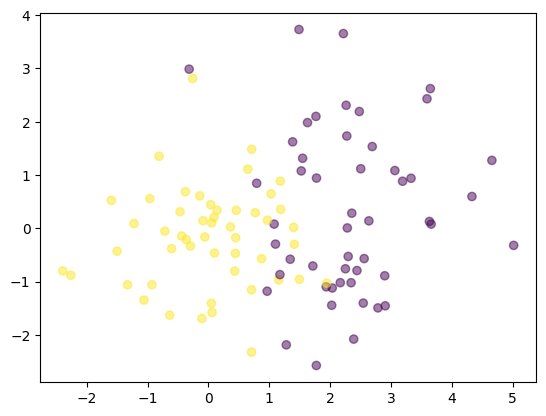

In [2]:
# Data generation

def generate_data(n_sample=100):
    # ------------------------------------
    # TODO: implement the data generation process
    # 
    # ------------------------------------
    positive_ratio, negative_ratio = 0.5, 0.25
    n_positive, n_nagetive = int(positive_ratio * n_sample), int(negative_ratio * n_sample)
    mean_positive = [0, 0]
    covariance_positive = [[1, 0], [0, 1]]
    positive_samples = np.random.multivariate_normal(mean_positive, covariance_positive, n_positive)

    # Generate samples for NEGATIVE label from first distribution
    mean_negative1 = [2, 2]
    covariance_negative1 = [[2, 0], [0, 2]]
    negative_samples1 = np.random.multivariate_normal(mean_negative1, covariance_negative1, n_nagetive)

    # Generate samples for NEGATIVE label from second distribution
    mean_negative2 = [2, -1]
    covariance_negative2 = [[0.5, 0], [0, 0.5]]
    negative_samples2 = np.random.multivariate_normal(mean_negative2, covariance_negative2, n_nagetive)

    samples = np.concatenate([positive_samples, negative_samples1, negative_samples2], axis=0)
    # labels = np.concatenate([['POSITIVE'] * n_positive, ['NEGATIVE']*(n_nagetive * 2)])
    labels = np.concatenate([[1] * n_positive, [-1]*(n_nagetive * 2)])

    indices = np.arange(n_sample)
    np.random.shuffle(indices)
    samples = samples[indices]
    labels = labels[indices]

    X = samples
    y = labels
    return X, y
    
# Run the following code to test your implementation
X_beta, y_beta = generate_data()
plt.scatter(X_beta[:, 0], X_beta[:, 1], c=y_beta, alpha=0.5)

### 1.1 Generate Test Data

Computing the true error in this case is much more compliciated than the one-dimensional case as illustrated in our lectures. Therefore, we are going to use an alternative method for approximating the true error: the following code will generate a large set of examples (3K) from the data generation function that you implemented before. We are going to use the same test data for all the following evaluation. 

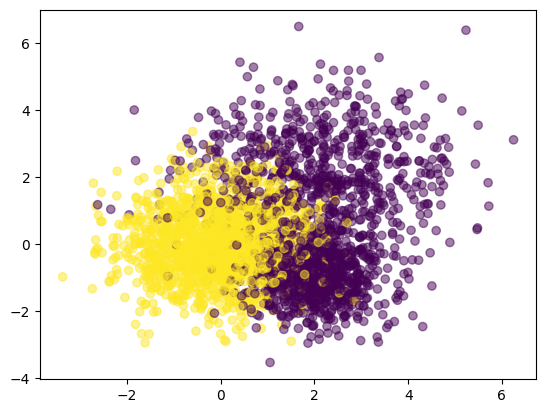

In [3]:
# Plot the test set, which can be used to approximate the ground-truth distribution
X_test, y_test = generate_data(n_sample=3000)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.5)

## 2. Training SVMs with Generated Data (3 points)

In this section, we will generate training data from the ground-truth data distribution, and train a SVM classifier with each specific training set.

In the `train()` function, for each iteration $n$, please implement the components:

1. Generate training data
2. Training a model
3. Test it on (X_test, y_test)
4. Attach the trained classifier to the list clfs, and the accuracy number to the list accs

As you can see, the function will also calcuate the mean of the variance of prediction accuracies, and return the list of classifiers `clfs` for further use. 

In [4]:
# 

def train(X_test, y_test, N=20, gamma=1.0):
    clfs, accs = [], []
    for n in tqdm (range (N), desc="Training models ..."):
        x, y = generate_data(n_sample=3000)
        # -----------------------------------
        # TODO: for each iteration n
        # 
        # ------------------------------------
        clf = SVC(gamma=gamma)
        clf.fit(x, y) 
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        clfs.append(clf)
        accs.append(accuracy)
    print("The mean accuracy: {} and its variance: {}".format(np.mean(accs), np.var(accs)))
    return clfs

# Run the following line to test the function before moving forward
train(X_test, y_test, N=2, gamma=0.1)

Training models ...: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

The mean accuracy: 0.8666666666666667 and its variance: 1.877777777777797e-05


[SVC(gamma=0.1), SVC(gamma=0.1)]

### 2.1 The Bayes predictor

Similar to the regression case, with the ground-truth data distribution, we can calculate the decision boundary given by the Bayes predictor. Although in this case, finding the analystical solution is compliciated, we are going to a numeric method for finding the decision boundary. 

In [5]:
# This code is ready to use

from scipy.stats import multivariate_normal

class Bayes_Predictor(object):
    def __init__(self):
        pass

    def predict(self, x):
        '''
        x - inputs
        '''
        pos = multivariate_normal([0,0], [[1,0],[0,1]])
        neg1 = multivariate_normal([2,2], [[2,0],[0,2]])
        neg2 = multivariate_normal([2,-2], [[0.5,0],[0,0.5]])
        pos_val = pos.pdf(x)
        neg1_val = neg1.pdf(x)
        neg2_val = neg2.pdf(x)
        # print(pos_val)
        # print(neg1_val)
        # print(neg2_val)
        labels = np.all([np.greater(pos_val, neg1_val), np.greater(pos_val, neg2_val)], axis=0)
        # print(labels)
        return labels


## 3. Plot Decision Boundaries

This is a function that is ready to use for drawing decision boundaries. It is **ready** to use. 

Note that, the first argument of `plot_decision_boundary` is a list of classification model. If you only have one classification model, then you need to put it in a list.

[Reference](https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot)

In [6]:
# This code is ready to use

def plot_decision_boundary(clfs, X_test, color='lightgray'):
    '''
    clfs - a list of classification models
    X_test - the inputs of the TEST data 
             (it requires the inputs only for determining the range of the input space)
    color - the color of the decision boundary
    '''
    h = .02  # step size in the mesh
    x1_min, x1_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    x2_min, x2_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))

    for n in tqdm(range(len(clfs)), desc="Plot decision boundaries ..."):
        clf = clfs[n]
        Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
        Z = Z.reshape(xx1.shape)
        plt.contour(xx1, xx2, Z, colors=color)


## 4. Put All Together (5 points)

The following code will put all functions together to draw 

### 4.1 Training SVMs with $\gamma=0.01$ (2 points)

With $\gamma=0.01$, we are going to visualize how the decision boundaries look like with different copies of training data. 

Please implement the following components with the functions that you defined before

- Use `train()` to train 10 different SVM models
- Plot the decision boundary of each SVM using `plot_decision_boundary`
- Use the Bayes predictor defined in the `Bayes_Predictor` class and draw its decision boundary using `plot_decision_boundary`

Please **keep all outputs** for grading.

Training models ...:   0%|          | 0/10 [00:00<?, ?it/s]

Training models ...: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


The mean accuracy: 0.8617333333333332 and its variance: 4.399999999999889e-07


Plot decision boundaries ...: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


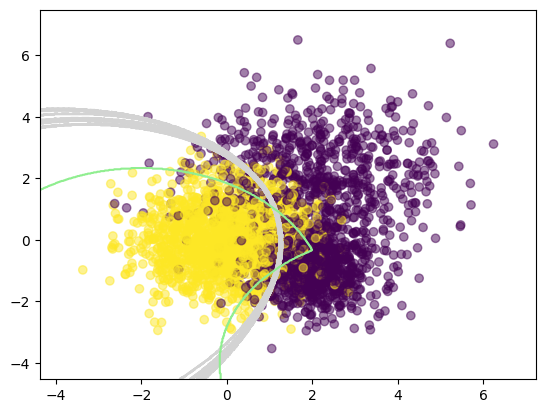

In [7]:
# Gamma: 0.01

# The hyper-parameter of the RBF kernel
gamma=0.01
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.5)

# TODO: Training a list of SVM models and plot their decision boundaries
# 
svms = train(X_test, y_test, 10, gamma=gamma)
plot_decision_boundary(svms, X_test)

# TODO: Plot the decision boundary of the Bayes predictor
# 
bayes = Bayes_Predictor()
plot_decision_boundary([bayes], X_test, color='lightgreen')

### 4.2 Training models with other $\gamma$ (1 point)

Now, let's train the models with two other $\gamma$'s using the following two code blocks

- $\gamma = 1.0$
- $\gamma = 10.0$

You can copy and paste the code from the previous block. And keep **all outputs** for grading. 

Training models ...:   0%|          | 0/10 [00:00<?, ?it/s]

Training models ...: 100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


The mean accuracy: 0.8673 and its variance: 4.587777777777851e-06


Plot decision boundaries ...: 100%|██████████| 10/10 [02:23<00:00, 14.31s/it]


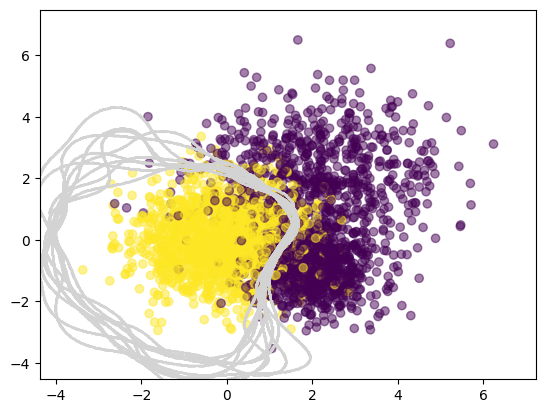

In [8]:
# Gamma: 1.0
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.5)
# TODO: Repeat the experiment with gamma=1.0
svms = train(X_test, y_test, 10, gamma=1.0)
plot_decision_boundary(svms, X_test)

Training models ...:   0%|          | 0/10 [00:00<?, ?it/s]

Training models ...: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


The mean accuracy: 0.8642 and its variance: 5.8044444444445235e-06


Plot decision boundaries ...: 100%|██████████| 10/10 [04:19<00:00, 25.90s/it]


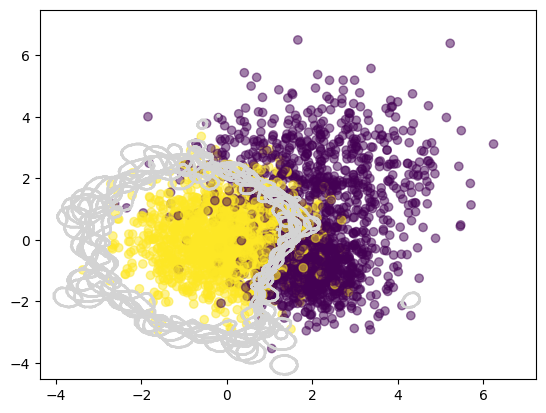

In [9]:
# Gamma: 10.0
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.5)
# TODO: Repeat the experiment with gamma=10.0
svms = train(X_test, y_test, 10, gamma=10.0)
plot_decision_boundary(svms, X_test)

### 4.3 Conclusion (2 points)

What conclusion you can get from the models with different $\gamma$'s. Please answer the question from the perspectives of 

- the mean prediction accuracy
- the variance of prediction accuracy
- the pattern of the decision boundaries.

TODO: *leave your answer here*

When you experiment with models having different values of the `gamma` (γ) parameter in the context of SVM with an RBF kernel, you'll observe the following changes in:

1. **Mean Prediction Accuracy**:
    - **Low Gamma**: The model is likely to be more biased and might not fit the training data very well, potentially leading to lower mean prediction accuracy.
    - **High Gamma**: Initially, as γ increases, the model fits the training data better, increasing the mean prediction accuracy. However, after a certain threshold, the model might overfit, and the mean prediction accuracy on the test data might decrease.

2. **Variance of Prediction Accuracy**:
    - **Low Gamma**: The variance of prediction accuracy is typically low because the model is more biased and less sensitive to variations in the training set.
    - **High Gamma**: The model becomes more flexible and can capture intricate patterns and noise in the data. This can lead to a high variance in prediction accuracy across different test sets or splits. In other words, the model's performance becomes more inconsistent across different datasets.

3. **Pattern of the Decision Boundaries**:
    - **Low Gamma**: The decision boundary will be smoother. It might not capture the complex patterns of the data, leading to potential misclassifications, especially if the underlying data has non-linear decision boundaries which actually represents underfitting.
    - **High Gamma**: The decision boundary becomes more wiggly or non-linear. This allows the model to closely fit to the training data, capturing its intricate patterns. However, this can also mean that the model captures noise, leading to a decision boundary that's too complex which actually represents overfitting.

In conclusion, while adjusting the `gamma` parameter, it's a balance between bias and variance. A low γ might result in underfitting, while a high γ might make the model too flexible, capturing noise and overfitting. We can use cross-validation to get optimal γ. 
